In [ ]:
!pip3 install ktrain

In [ ]:
!pip install https://github.com/amaiya/eli5/archive/refs/heads/tfkeras_0_10_1.zip

  Using cached https://github.com/amaiya/eli5/archive/refs/heads/tfkeras_0_10_1.zip


In [ ]:
!pip install unidecode

In [ ]:
base_path = '/content/drive/My Drive/wassa/'


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
classes = ['anger', 'joy', 'sadness', 'fear']

class_mapping = {}
for idx, name in enumerate(classes):
    class_mapping[name] = idx 
no_classes = len(classes)

In [ ]:
cols = ['tweet', 'tweettype']

In [ ]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", 
                   "can't've": "cannot have", "'cause": "because", "could've": "could have", 
                   "couldn't": "could not", "couldn't've": "could not have","didn't": "did not", 
                   "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
                   "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", 
                   "he'd": "he would", "he'd've": "he would have", "he'll": "he will", 
                   "he'll've": "he will have", "he's": "he is", "how'd": "how did", 
                   "how'd'y": "how do you", "how'll": "how will", "how's": "how is", 
                   "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
                   "I'll've": "I will have","I'm": "I am", "I've": "I have", 
                   "i'd": "i would", "i'd've": "i would have", "i'll": "i will", 
                   "i'll've": "i will have","i'm": "i am", "i've": "i have", 
                   "isn't": "is not", "it'd": "it would", "it'd've": "it would have", 
                   "it'll": "it will", "it'll've": "it will have","it's": "it is", 
                   "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
                   "might've": "might have","mightn't": "might not","mightn't've": "might not have", 
                   "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", 
                   "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", 
                   "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                   "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
                   "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", 
                   "she's": "she is", "should've": "should have", "shouldn't": "should not", 
                   "shouldn't've": "should not have", "so've": "so have","so's": "so as", 
                   "this's": "this is",
                   "that'd": "that would", "that'd've": "that would have","that's": "that is", 
                   "there'd": "there would", "there'd've": "there would have","there's": "there is", 
                       "here's": "here is",
                   "they'd": "they would", "they'd've": "they would have", "they'll": "they will", 
                   "they'll've": "they will have", "they're": "they are", "they've": "they have", 
                   "to've": "to have", "wasn't": "was not", "we'd": "we would", 
                   "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", 
                   "we're": "we are", "we've": "we have", "weren't": "were not", 
                   "what'll": "what will", "what'll've": "what will have", "what're": "what are", 
                   "what's": "what is", "what've": "what have", "when's": "when is", 
                   "when've": "when have", "where'd": "where did", "where's": "where is", 
                   "where've": "where have", "who'll": "who will", "who'll've": "who will have", 
                   "who's": "who is", "who've": "who have", "why's": "why is", 
                   "why've": "why have", "will've": "will have", "won't": "will not", 
                   "won't've": "will not have", "would've": "would have", "wouldn't": "would not", 
                   "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                   "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                   "you'd": "you would", "you'd've": "you would have", "you'll": "you will", 
                   "you'll've": "you will have", "you're": "you are", "you've": "you have" }

In [ ]:
import codecs
import unidecode
import re
import spacy
nlp = spacy.load('en')

def spacy_cleaner(text):
    try:
        decoded = unidecode.unidecode(codecs.decode(text, 'unicode_escape'))
    except:
        decoded = unidecode.unidecode(text)
    apostrophe_handled = re.sub("’", "'", decoded)
    expanded = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in apostrophe_handled.split(" ")])
    parsed = nlp(expanded)
    final_tokens = []
    for t in parsed:
        if t.is_punct or t.is_space or t.like_num or t.like_url or str(t).startswith('@'):
            pass
        else:
            if t.lemma_ == '-PRON-':
                final_tokens.append(str(t))
            else:
                sc_removed = re.sub("[^a-zA-Z]", '', str(t.lemma_))
                if len(sc_removed) > 1:
                    final_tokens.append(sc_removed)
    joined = ' '.join(final_tokens)
    spell_corrected = re.sub(r'(.)\1+', r'\1\1', joined)
    return spell_corrected

In [ ]:
def clean_text(data):
    data = (re.sub(r"(#[\d\w\.]+)", '', data)).lower()
    data = emoji.demojize(data)
    data = spacy_cleaner(data)
    return data

In [ ]:
def build_dataset(df, feature='text', target='label'):
    dataset = (
                tf.data.Dataset.from_tensor_slices(
                    (
                        tf.cast(df[feature].values, tf.string),
                        tf.cast(df[target].values, tf.int32)
                    )
                )
            )
    return dataset

In [ ]:
def load_dataset(directory, ending, threshold = 0, testing = False):

    df_list = []

    for emotion in classes:
        file_name = f'{base_path}{directory}/{emotion}{ending}'
        df = pd.read_csv(file_name, delimiter='\t')
        
        stop = stopwords.words('english')
        df['tweet'] = df['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
        
        if not testing:
            df = df[df['score'] > threshold]
        
        df = df[cols]
        
        df['tweet'] = df['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
        df['tweet'] = df['tweet'].apply(clean_text)        
        df['tweettype'] = df['tweettype'].apply(lambda x : class_mapping[x])        

        df_list.append(df)

    df = pd.concat(df_list)
    df = df.rename(columns = {'tweet' : 'text', 'tweettype' : 'label'})
    print('Distribution of data: ')
    print(df['label'].value_counts())
    
    labels = df['label'].values
    
    dataset = build_dataset(df)
    
    return dataset, labels, df

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
!pip install emoji

In [ ]:
import pandas as pd
from nltk.corpus import stopwords
import emoji
import tensorflow as tf

# Training
threshold = 0

directory = 'training'
ending = '-ratings-0to1.train.txt'

train_dataset,_, df_train = load_dataset(directory, ending, threshold = threshold)

Distribution of data: 
3    1147
0     857
1     823
2     786
Name: label, dtype: int64


In [ ]:
df_train

,text,label
0,how fuk who heck move fridge knock landlord door,0
1,so indian uber driver call someone word if mov...,0
2,ask parcel deliver pick store address,0
3,ef whichever butt wipe pull fire alarm davis b...,0
4,do not join put phone you talk rude take money...,0
...,...,...
1142,pull make car facesavoringfoodsweatdroplet,3
1143,awe be not sweetheart he be adorable smilingfa...,3
1144,steak pie supper,3
1145,awe thank much love twohearts,3


In [ ]:
# Validation

directory = 'validation'
ending = '-ratings-0to1.dev.gold.txt'

val_dataset,_, df_val = load_dataset(directory, ending)

Distribution of data: 
3    110
0     84
1     79
2     74
Name: label, dtype: int64


In [ ]:
# Testing

directory = 'testing'
ending = '-ratings-0to1.test.target.txt'

test_dataset, y_test, df_test = load_dataset(directory, ending, testing = True)

Distribution of data: 
3    995
0    760
1    714
2    673
Name: label, dtype: int64


In [ ]:
X_train = df_train.text.tolist()
X_test = df_val.text.tolist()

y_train = df_train.label.tolist()
y_test = df_val.label.tolist()

data = df_train.append(df_val, ignore_index=True)

print('size of training set: %s' % (len(df_train['text'])))
print('size of validation set: %s' % (len(df_val['text'])))
print(data.label.value_counts())

data.head(10)

size of training set: 3613
size of validation set: 347
3    1257
0     941
1     902
2     860
Name: label, dtype: int64


,text,label
0,how fuk who heck move fridge knock landlord door,0
1,so indian uber driver call someone word if mov...,0
2,ask parcel deliver pick store address,0
3,ef whichever butt wipe pull fire alarm davis b...,0
4,do not join put phone you talk rude take money...,0
5,my blood boiling,0
6,when still get whole season wentworth watch st...,0
7,tracking show equipment deliver be not why ser...,0
8,legit furious him people fucking idiot,0
9,how suppose work that wtf dude thank piss off,0


In [ ]:
import ktrain
from ktrain import text

class_names=[0,1,2,3]

(x_train,  y_train), (x_test, y_test), preproc = text.texts_from_array(x_train=X_train, y_train=y_train,
                                                                       x_test=X_test, y_test=y_test,
                                                                       class_names=class_names,
                                                                       preprocess_mode='bert',
                                                                       lang='en',
                                                                       maxlen=350, 
                                                                       max_features=35000)

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


task: text classification


In [ ]:
model = text.text_classifier('bert', train_data=(x_train, y_train), preproc=preproc)

Is Multi-Label? False
maxlen is 350
done.


In [ ]:
learner = ktrain.get_learner(model, train_data=(x_train, y_train), 
                             val_data=(x_test, y_test),
                             batch_size=6)


simulating training for different learning rates... this may take a few moments...


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/1024
603/603 [==============================] - 629s 998ms/step - loss: 1.4505 - accuracy: 0.3086
Epoch 2/1024
603/603 [==============================] - 603s 999ms/step - loss: 1.8384 - accuracy: 0.3443
Epoch 3/1024
603/603 [==============================] - 40s 65ms/step - loss: 8.3571 - accuracy: 0.2375


done.
Visually inspect loss plot and select learning rate associated with falling loss


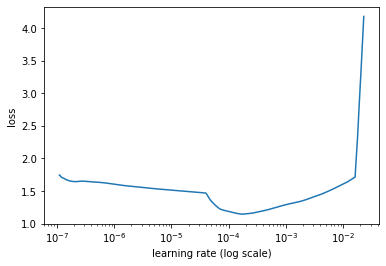

In [ ]:
learner.lr_find(show_plot=True)

In [ ]:
learner.autofit(2e-5, monitor='val_accuracy')

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.001...
Epoch 1/1024
 13/603 [..............................] - ETA: 9:49 - loss: 1.3916 - accuracy: 0.3205

In [ ]:
learner.validate(val_data=(x_test, y_test), class_names=class_names)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        84
           1       0.00      0.00      0.00        79
           2       0.00      0.00      0.00        74
           3       0.32      1.00      0.48       110

    accuracy                           0.32       347
   macro avg       0.08      0.25      0.12       347
weighted avg       0.10      0.32      0.15       347



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[  0,   0,   0,  84],
       [  0,   0,   0,  79],
       [  0,   0,   0,  74],
       [  0,   0,   0, 110]])

In [ ]:
#on purely test data
X_test = df_test.text.tolist()
y_test = df_test.label.tolist()

(x_train,  y_train), (x_test, y_test), preproc = text.texts_from_array(x_train=X_train, y_train=y_train,
                                                                       x_test=X_test, y_test=y_test,
                                                                       class_names=class_names,
                                                                       preprocess_mode='bert',
                                                                       lang='en',
                                                                       maxlen=350, 
                                                                       max_features=35000)

learner.validate(val_data=(x_test, y_test), class_names=class_names)

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


task: text classification
              precision    recall  f1-score   support

           0       0.71      0.66      0.68       760
           1       0.79      0.74      0.76       714
           2       0.60      0.66      0.63       673
           3       0.65      0.67      0.66       995

    accuracy                           0.68      3142
   macro avg       0.69      0.68      0.68      3142
weighted avg       0.69      0.68      0.68      3142



array([[502,  34,  88, 136],
       [ 39, 525,  48, 102],
       [ 62,  40, 447, 124],
       [103,  67, 157, 668]])

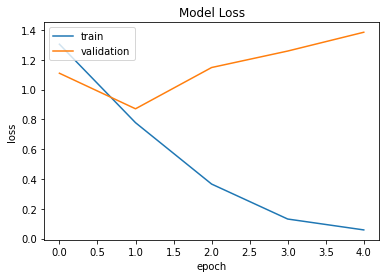

In [ ]:
learner.plot()

FAST TEXT

In [ ]:
X_train = df_train.text.tolist()
X_test = df_val.text.tolist()

y_train = df_train.label.tolist()
y_test = df_val.label.tolist()

data = df_train.append(df_val, ignore_index=True)

print('size of training set: %s' % (len(df_train['text'])))
print('size of validation set: %s' % (len(df_val['text'])))
print(data.label.value_counts())

data.head(10)

size of training set: 3613
size of validation set: 347
3    1257
0     941
1     902
2     860
Name: label, dtype: int64


,text,label
0,how fuk who heck move fridge knock landlord door,0
1,so indian uber driver call someone word if mov...,0
2,ask parcel deliver pick store address,0
3,ef whichever butt wipe pull fire alarm davis b...,0
4,do not join put phone you talk rude take money...,0
5,my blood boiling,0
6,when still get whole season wentworth watch st...,0
7,tracking show equipment deliver be not why ser...,0
8,legit furious him people fucking idiot,0
9,how suppose work that wtf dude thank piss off,0


In [ ]:
import ktrain
from ktrain import text

class_names=[0,1,2,3]

(x_train,  y_train), (x_test, y_test), preproc = text.texts_from_array(x_train=X_train, y_train=y_train,
                                                                       x_test=X_test, y_test=y_test,
                                                                       class_names=class_names,
                                                                       lang='en',
                                                                       maxlen=350, 
                                                                       max_features=35000)

language: en
Word Counts: 6275
Nrows: 3613
3613 train sequences
train sequence lengths:
	mean : 9
	95percentile : 15
	99percentile : 18
x_train shape: (3613,350)
y_train shape: (3613, 4)
Is Multi-Label? False
347 test sequences
test sequence lengths:
	mean : 8
	95percentile : 13
	99percentile : 17
x_test shape: (347,350)
y_test shape: (347, 4)
task: text classification


In [ ]:
# define model a fastText-like architecture using ktrain
model = text.text_classifier('fasttext', train_data=(x_train, y_train), preproc=preproc)

Is Multi-Label? False
compiling word ID features...
maxlen is 350
done.


In [ ]:
# wrap model and data in Learner object
learner = ktrain.get_learner(model, train_data=(x_train, y_train), 
                             val_data=(x_test, y_test),
                             batch_size=6)

simulating training for different learning rates... this may take a few moments...
Epoch 1/1024
603/603 [==============================] - 6s 9ms/step - loss: 1.8150 - accuracy: 0.2447
Epoch 2/1024
603/603 [==============================] - 6s 9ms/step - loss: 1.6469 - accuracy: 0.2804
Epoch 3/1024
603/603 [==============================] - 4s 7ms/step - loss: 329.1958 - accuracy: 0.2918


done.
Visually inspect loss plot and select learning rate associated with falling loss


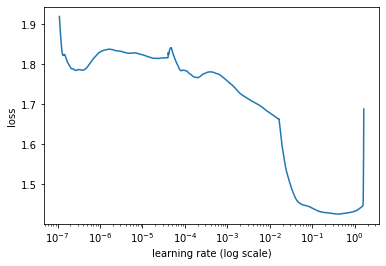

In [ ]:
learner.lr_find(show_plot=True)

In [ ]:
#learner.fit_onecycle(2e-5, 5)
learner.autofit(7e-3, monitor='val_accuracy')

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.007...
Epoch 1/1024
603/603 [==============================] - 7s 11ms/step - loss: 1.4721 - accuracy: 0.3191 - val_loss: 1.3085 - val_accuracy: 0.4323
Epoch 2/1024
603/603 [==============================] - 6s 11ms/step - loss: 1.2229 - accuracy: 0.4559 - val_loss: 1.1137 - val_accuracy: 0.5389
Epoch 3/1024
603/603 [==============================] - 6s 10ms/step - loss: 1.0602 - accuracy: 0.5544 - val_loss: 1.0512 - val_accuracy: 0.5994
Epoch 4/1024
603/603 [==============================] - 6s 11ms/step - loss: 0.9490 - accuracy: 0.6183 - val_loss: 0.9681 - val_accuracy: 0.6455
Epoch 5/1024
603/603 [==============================] - 6s 10ms/step - loss: 0.8492 - accuracy: 0.6809 - val_loss: 0.8817 - val_accuracy: 0.6772
Epoch 6/1024
603/603 [==============================] - 6s 11ms/step - loss: 0.7345 - accur

In [ ]:
learner.validate(val_data=(x_test, y_test), class_names=class_names)

              precision    recall  f1-score   support

           0       0.68      0.62      0.65        84
           1       0.80      0.71      0.75        79
           2       0.60      0.66      0.63        74
           3       0.66      0.72      0.69       110

    accuracy                           0.68       347
   macro avg       0.69      0.68      0.68       347
weighted avg       0.69      0.68      0.68       347



array([[52,  4, 13, 15],
       [ 8, 56,  4, 11],
       [ 4,  6, 49, 15],
       [12,  4, 15, 79]])

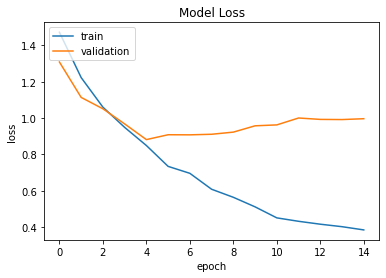

In [ ]:
learner.plot()

In [ ]:
#on purely test data
X_test = df_test.text.tolist()
y_test = df_test.label.tolist()

(x_train,  y_train), (x_test, y_test), preproc = text.texts_from_array(x_train=X_train, y_train=y_train,
                                                                       x_test=X_test, y_test=y_test,
                                                                       class_names=class_names,
                                                                       lang='en',
                                                                       maxlen=350, 
                                                                       max_features=35000)

learner.validate(val_data=(x_test, y_test), class_names=class_names)

language: en
Word Counts: 6275
Nrows: 3613
3613 train sequences
train sequence lengths:
	mean : 9
	95percentile : 15
	99percentile : 18
x_train shape: (3613,350)
y_train shape: (3613, 4)
Is Multi-Label? False
3142 test sequences
test sequence lengths:
	mean : 8
	95percentile : 14
	99percentile : 17
x_test shape: (3142,350)
y_test shape: (3142, 4)
task: text classification
              precision    recall  f1-score   support

           0       0.66      0.63      0.64       760
           1       0.80      0.65      0.72       714
           2       0.58      0.62      0.60       673
           3       0.63      0.70      0.67       995

    accuracy                           0.66      3142
   macro avg       0.67      0.65      0.66      3142
weighted avg       0.66      0.66      0.66      3142



array([[479,  36,  91, 154],
       [ 64, 465,  77, 108],
       [ 81,  32, 419, 141],
       [103,  50, 141, 701]])

**NBSVM**

In [ ]:
X_train = df_train.text.tolist()
X_test = df_val.text.tolist()

y_train = df_train.label.tolist()
y_test = df_val.label.tolist()

data = df_train.append(df_val, ignore_index=True)

print('size of training set: %s' % (len(df_train['text'])))
print('size of validation set: %s' % (len(df_val['text'])))
print(data.label.value_counts())

data.head(10)

size of training set: 3613
size of validation set: 347
3    1257
0     941
1     902
2     860
Name: label, dtype: int64


,text,label
0,how fuk who heck move fridge knock landlord door,0
1,so indian uber driver call someone word if mov...,0
2,ask parcel deliver pick store address,0
3,ef whichever butt wipe pull fire alarm davis b...,0
4,do not join put phone you talk rude take money...,0
5,my blood boiling,0
6,when still get whole season wentworth watch st...,0
7,tracking show equipment deliver be not why ser...,0
8,legit furious him people fucking idiot,0
9,how suppose work that wtf dude thank piss off,0


In [ ]:
import ktrain
from ktrain import text

class_names=[0,1,2,3]

(x_train,  y_train), (x_test, y_test), preproc = text.texts_from_array(x_train=X_train, y_train=y_train,
                                                                       x_test=X_test, y_test=y_test,
                                                                       class_names=class_names,
                                                                       preprocess_mode='standard',
                                                                       lang='en',
                                                                       maxlen=350, 
                                                                       val_pct=0.1,
                                                                       ngram_range=3,
                                                                       max_features=35000)

language: en
Word Counts: 6275
Nrows: 3613
3613 train sequences
train sequence lengths:
	mean : 9
	95percentile : 15
	99percentile : 18
Adding 3-gram features
max_features changed to 75808 with addition of ngrams
Average train sequence length with ngrams: 22
train (w/ngrams) sequence lengths:
	mean : 23
	95percentile : 42
	99percentile : 51
x_train shape: (3613,350)
y_train shape: (3613, 4)
Is Multi-Label? False
347 test sequences
test sequence lengths:
	mean : 8
	95percentile : 13
	99percentile : 17
Average test sequence length with ngrams: 9
test (w/ngrams) sequence lengths:
	mean : 9
	95percentile : 18
	99percentile : 26
x_test shape: (347,350)
y_test shape: (347, 4)
task: text classification


In [ ]:
# define model a fastText-like architecture using ktrain
model = text.text_classifier('nbsvm', train_data=(x_train, y_train) , preproc=preproc)

learner = ktrain.get_learner(model, train_data=(x_train, y_train), 
                             val_data=(x_test, y_test),
                             batch_size=6)

Is Multi-Label? False
compiling word ID features...
maxlen is 350
building document-term matrix... this may take a few moments...
rows: 1-3613
computing log-count ratios...
done.


simulating training for different learning rates... this may take a few moments...
Epoch 1/1024
603/603 [==============================] - 4s 6ms/step - loss: 1.3856 - accuracy: 0.4210
Epoch 2/1024
603/603 [==============================] - 4s 6ms/step - loss: 1.2434 - accuracy: 0.7182
Epoch 3/1024
603/603 [==============================] - 3s 6ms/step - loss: 2.3221 - accuracy: 0.8527


done.
Visually inspect loss plot and select learning rate associated with falling loss


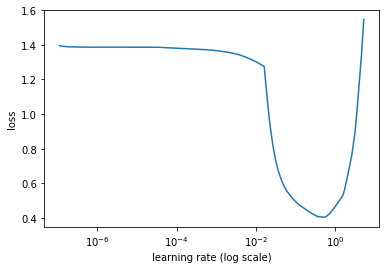

In [ ]:
learner.lr_find(show_plot=True)

In [ ]:
learner.autofit(7e-3, monitor='val_accuracy')

early_stopping automatically enabled at patience=5
reduce_on_plateau automatically enabled at patience=2


begin training using triangular learning rate policy with max lr of 0.007...
Epoch 1/1024
603/603 [==============================] - 5s 8ms/step - loss: 0.3360 - accuracy: 0.9820 - val_loss: 13.0535 - val_accuracy: 0.5879
Epoch 2/1024
603/603 [==============================] - 5s 7ms/step - loss: 0.3262 - accuracy: 0.9820 - val_loss: 13.0493 - val_accuracy: 0.5879
Epoch 3/1024
598/603 [============================>.] - ETA: 0s - loss: 0.3192 - accuracy: 0.9822
Epoch 00003: Reducing Max LR on Plateau: new max lr will be 0.0035 (if not early_stopping).
603/603 [==============================] - 4s 7ms/step - loss: 0.3170 - accuracy: 0.9823 - val_loss: 13.0444 - val_accuracy: 0.5879
Epoch 4/1024
603/603 [==============================] - 4s 7ms/step - loss: 0.3057 - accuracy: 0.9823 - val_loss: 13.0434 - val_accuracy: 0.5879
Epoch 5/1024
601/603 [============================>.] - ETA

In [ ]:
learner.validate(val_data=(x_test, y_test), class_names=class_names)

              precision    recall  f1-score   support

           0       0.57      0.61      0.59        84
           1       0.69      0.63      0.66        79
           2       0.45      0.62      0.52        74
           3       0.70      0.52      0.59       110

    accuracy                           0.59       347
   macro avg       0.60      0.59      0.59       347
weighted avg       0.61      0.59      0.59       347



array([[51,  6, 18,  9],
       [ 5, 50, 18,  6],
       [12,  6, 46, 10],
       [22, 10, 21, 57]])

In [ ]:
#on purely test data
X_test = df_test.text.tolist()
y_test = df_test.label.tolist()

(x_train,  y_train), (x_test, y_test), preproc = text.texts_from_array(x_train=X_train, y_train=y_train,
                                                                       x_test=X_test, y_test=y_test,
                                                                       class_names=class_names,
                                                                       lang='en',
                                                                       maxlen=350, 
                                                                       max_features=35000)

learner.validate(val_data=(x_test, y_test), class_names=class_names)

language: en
Word Counts: 6275
Nrows: 3613
3613 train sequences
train sequence lengths:
	mean : 9
	95percentile : 15
	99percentile : 18
x_train shape: (3613,350)
y_train shape: (3613, 4)
Is Multi-Label? False
3142 test sequences
test sequence lengths:
	mean : 8
	95percentile : 14
	99percentile : 17
x_test shape: (3142,350)
y_test shape: (3142, 4)
task: text classification
              precision    recall  f1-score   support

           0       0.59      0.62      0.61       760
           1       0.67      0.63      0.65       714
           2       0.50      0.64      0.56       673
           3       0.66      0.53      0.59       995

    accuracy                           0.60      3142
   macro avg       0.60      0.61      0.60      3142
weighted avg       0.61      0.60      0.60      3142



array([[474,  60, 115, 111],
       [ 71, 453, 110,  80],
       [109,  55, 432,  77],
       [151, 111, 208, 525]])

In [ ]:
learner.view_top_losses(n=1, preproc=preproc)

----------
id:4 | loss:16.12 | true:0 | pred:2)

sometimes get mad something try ruin somebody life like lose job like get federal
